In [15]:
# Importing the libraries
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.timeseries import LombScargle
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, solar_system_ephemeris
from astropy.coordinates import AltAz, ICRS

from wise_light_curves import *

In [16]:
# Plot settings
plt.rc("font", size=10)
plt.rcParams['font.family'] = 'Liberation Serif'

In [17]:
# Importing the data
tess = 'hlsp_qlp_tess_ffi_s0065-0000000410922760_tess_v01_llc.fits'

ra = 178.10721 
dec = -66.96506
download_single_data(name='WISE J115225.7-665754', ra=ra, dec=dec, root_path='data/', radius=2.)

allwise = ascii.read('data/WISE J115225.7-665754_allwise.ipac', format='ipac')
neowise = ascii.read('data/WISE J115225.7-665754_neowise.ipac', format='ipac')

In [18]:
# Functions
def mjd_to_bjd(allwise, neowise, t):
    allwise_ra = np.array(allwise['ra'])
    neowise_ra = np.array(neowise['ra'])
    conc_ra = np.concatenate((allwise_ra, neowise_ra))
    
    allwise_dec = np.array(allwise['dec'])
    neowise_dec = np.array(neowise['dec'])
    conc_dec = np.concatenate((allwise_dec, neowise_dec))

    jd = t + 2400000.5

    time_conversion = Time(jd, format='jd', scale='utc')

    target_coord = SkyCoord(conc_ra, conc_dec, unit="deg", frame="icrs")

    observer_location = EarthLocation.of_site("greenwich")  

    with solar_system_ephemeris.set('builtin'):
        ltt_bary = time_conversion.light_travel_time(target_coord, location=observer_location)

    bjd_tdb = time_conversion.tdb + ltt_bary

    return np.array(bjd_tdb)

Best-fit period: 2.040402734307127


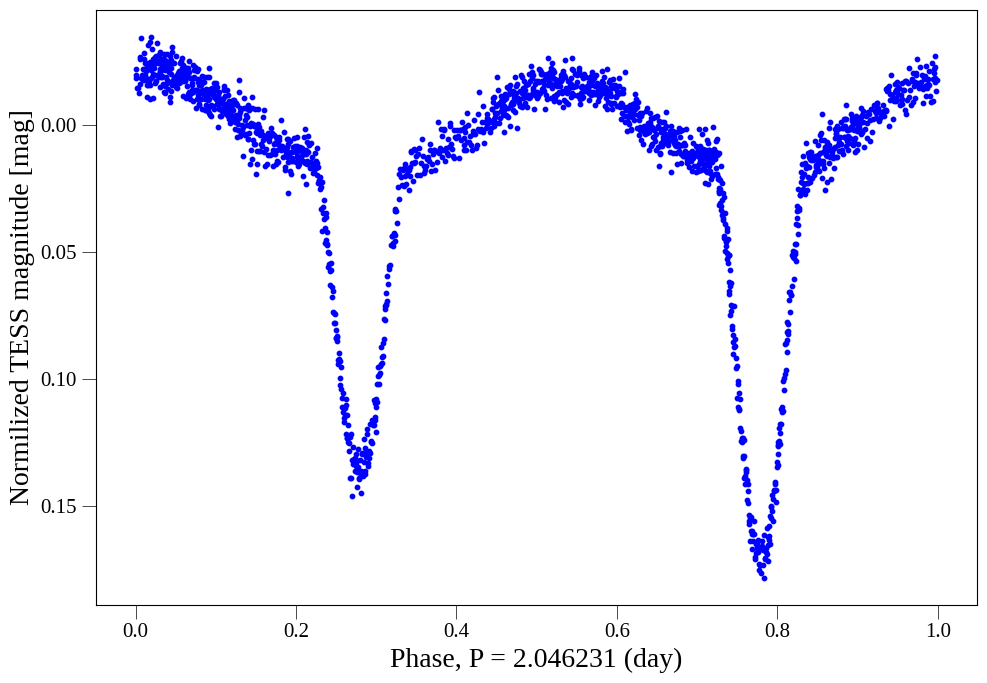

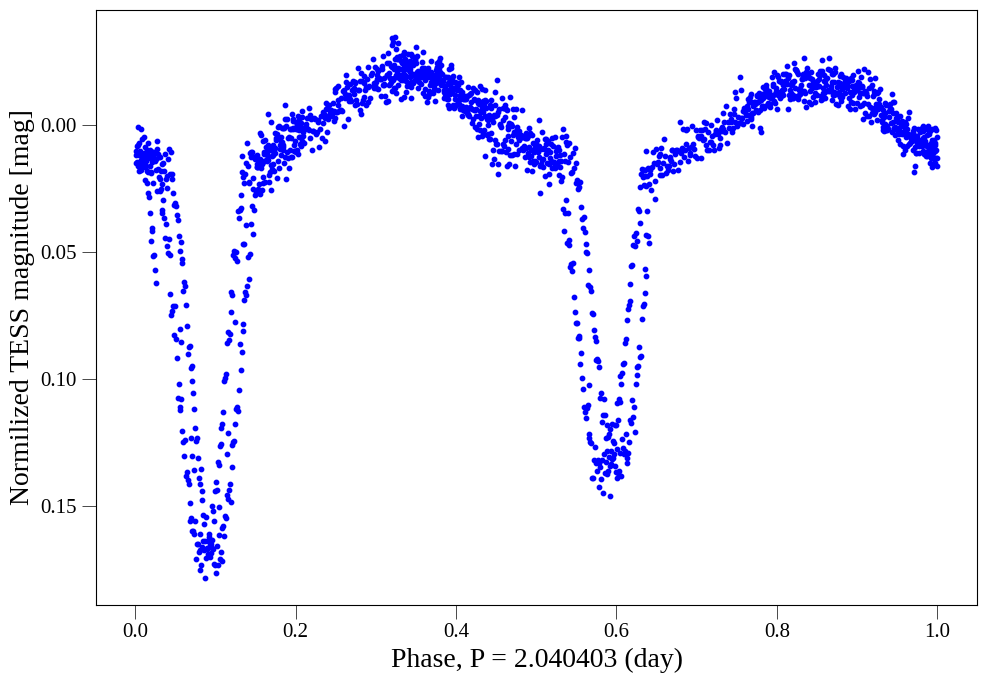

In [19]:
# Tess data
with fits.open(f'data/{tess}') as hdul:
    data = hdul[1].data 

    # primary_header = hdul[0].header
    # secondary_header = hdul[1].header

    # Sorting good tome intervals
    qual_flags = hdul[1].data['QUALITY']
    where_gt0 = np.where(qual_flags > 0)[0]

    time_tess = data['TIME'][where_gt0]
    flux_tess = data['SAP_FLUX'][where_gt0]

    valid_indices = flux_tess >= 0.75
    time_tess = time_tess[valid_indices]
    flux_tess = flux_tess[valid_indices]

    mag_tess_orig = -2.5*np.log10(flux_tess)

    # Fitting the period and calculating phase
    frequency, power = LombScargle(time_tess, mag_tess_orig).autopower()
    period = 1 / frequency[np.argmax(power)] * 2
    print(f"Best-fit period: {period}")

    phase = (time_tess % period) / period

    sorted_indices = np.argsort(phase)
    phase = phase[sorted_indices]
    mag_tess = mag_tess_orig[sorted_indices]

    # AAVSO data
    period_aavso = 2.0462307

    phase_aavso = (time_tess % period_aavso) / period_aavso

    sorted_indices_aavso = np.argsort(phase_aavso)
    phase_aavso = phase_aavso[sorted_indices_aavso]
    mag_tess_aavso = mag_tess_orig[sorted_indices_aavso]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))

    ax.set_xlabel('Phase, P = {:.7} (day)'.format(period_aavso))
    ax.yaxis.label.set_fontsize(20)
    ax.set_ylabel('Normilized TESS magnitude [mag]')
    ax.xaxis.label.set_fontsize(20)
    ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
    ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
    ax.invert_yaxis()
    plt.tight_layout()  

    ax.scatter(phase_aavso, mag_tess_aavso, color='blue', s=10)

    # ax.legend(loc='upper right', fontsize=15)

    plt.savefig('images/tess_lc_1.png', bbox_inches='tight')

    plt.show()

    fig, ax = plt.subplots(figsize=(10, 7))

    ax.set_xlabel('Phase, P = {:.7} (day)'.format(period))
    ax.yaxis.label.set_fontsize(20)
    ax.set_ylabel('Normilized TESS magnitude [mag]')
    ax.xaxis.label.set_fontsize(20)
    ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
    ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
    ax.invert_yaxis()
    plt.tight_layout()  

    ax.scatter(phase, mag_tess, color='blue', s=10)

    # ax.legend(loc='upper right', fontsize=15)

    plt.savefig('images/tess_lc_2.png', bbox_inches='tight')

    plt.show()

    # TESS data to csv
    data = {
        'BJD': time_tess+2457000,
        'mag': mag_tess_orig,
        'filter': ['TESS'] * len(time_tess),
        'instrument': ['TESS'] * len(time_tess)
    }

    df = pd.DataFrame(data)

    df.to_csv('output/tess_data.csv', index=False)

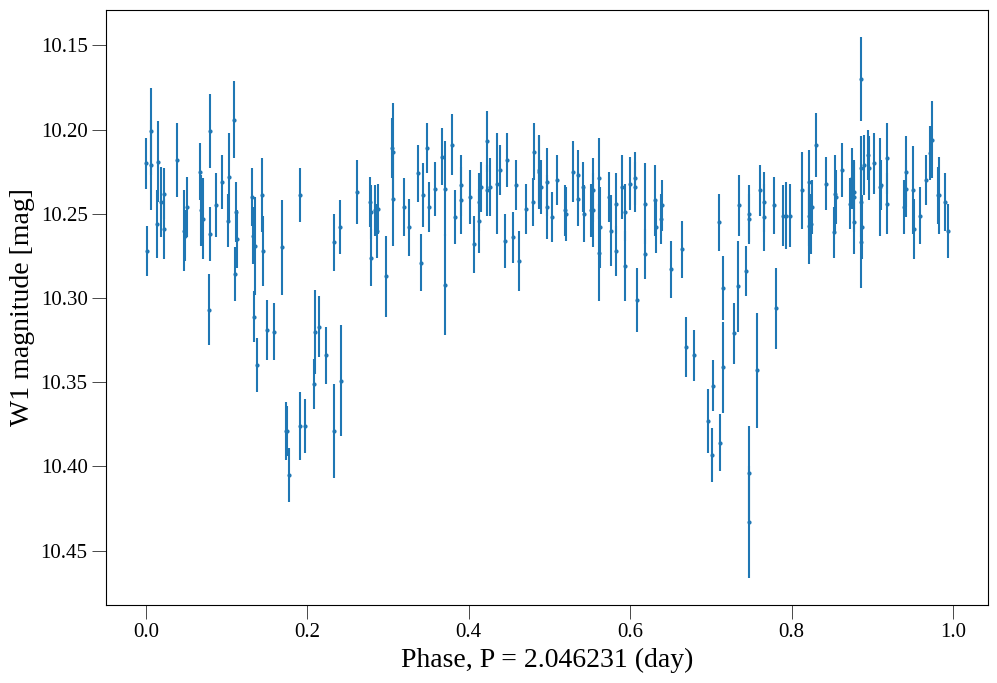

In [20]:
# WISE data
allwise, neowise = only_good_data_v1(allwise, neowise)

t, mag, mag_err, filts = make_full_lightcurve_multibands(allwise, neowise)
t_w1 = t[filts == 'w1']
mag_w1 = mag[filts == 'w1']
mag_err_w1 = mag_err[filts == 'w1']

bjd_time = mjd_to_bjd(allwise, neowise, t_w1)

fig, ax = plt.subplots(figsize=(10, 7))

ax.set_xlabel('Phase, P = {:.7} (day)'.format(period_aavso))
ax.yaxis.label.set_fontsize(20)
ax.set_ylabel('W1 magnitude [mag]')
ax.xaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
ax.invert_yaxis()
plt.tight_layout()  

ax.errorbar((t_w1 % period_aavso) / period_aavso, mag_w1, mag_err_w1, fmt='o', ms=2.)

# ax.legend(loc='upper right', fontsize=15)

plt.savefig('images/wise_lc.png', bbox_inches='tight')
plt.show()

# WISE data to csv
data = {
    'BJD': bjd_time,
    'mag': mag_w1,
    'mag_err': mag_err_w1,
    'filter': ['W1'] * len(bjd_time),
    'instrument': ['WISE'] * len(bjd_time)
}
df = pd.DataFrame(data)
df.to_csv('output/wise_data.csv', index=False)
